In [5]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import time
from math import sin, cos, radians

### Getting inputs

In [6]:
!wget https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20background.jpg

--2020-10-25 15:30:51--  https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20background.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9661 (9.4K) [image/jpeg]
Saving to: ‘input background.jpg.1’

input background.jp 100%[===================>]   9.43K  --.-KB/s    in 0s      

2020-10-25 15:30:52 (79.4 MB/s) - ‘input background.jpg.1’ saved [9661/9661]



In [7]:
!wget https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20image.jpg

--2020-10-25 15:30:52--  https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20image.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21020 (21K) [image/jpeg]
Saving to: ‘input image.jpg.1’

input image.jpg.1   100%[===================>]  20.53K  --.-KB/s    in 0.01s   

2020-10-25 15:30:53 (1.64 MB/s) - ‘input image.jpg.1’ saved [21020/21020]



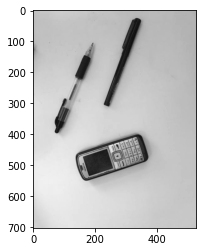

In [8]:
img1 = imread('input background.jpg')
if img1.ndim == 3:
    img1 = img1.mean(axis=2)

img2 = imread('input image.jpg')
if img2.ndim == 3:
    img2 = img2.mean(axis=2)
    
plt.imshow(img2, cmap='gray')

### Functions

In [9]:
def median_filter(input_image, s):
  new_image = np.zeros((input_image.shape[0], input_image.shape[1]))
  for r in range(0, input_image.shape[1]):
    for c in range(0, input_image.shape[0]):
      values = []
      for ri in range(max(0, r - s), min(input_image.shape[1], r + s)):
        for ci in range(max(0, c - s), min(input_image.shape[0], c + s)):
          values.append(input_image[ci, ri])
      values = sorted(values)
      new_image[c, r] = values[int(len(values) / 2)]
  return new_image

In [10]:
threshold_function = lambda image, threshold : np.asarray([[pixel>=threshold for pixel in row] for row in image])

In [11]:
downsize = lambda img, sf : np.array([[img[j, i] for i in range(0, len(img[0]), sf)] for j in range(0, len(img), sf)])

In [12]:
def dilate(image, radius):
  new_image = np.zeros(image.shape)
  image = np.pad(image, radius)
  for y in range(2, image.shape[0]-2):
    for x in range(2, image.shape[1]-2):
      coords = [[(y+j, x+i) for j in range(-radius, radius+1)] for i in range(-radius, radius+1)]
      total = np.asarray([[image[j] for j in i] for i in coords]).any()
      new_image[y-radius*2, x-radius*2] = total != 0
  return new_image

In [13]:
def DBSCAN(image, radius, core_threshold):

  def RangeQuery(points, point1, radius):

    def dist(p1, p2):
      return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

    neighbors = []
    for point2 in points:
        if dist(point1[0], point2[0]) <= radius:
            neighbors.append(point2)
    return neighbors

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append([(y,x), -1])

  cluster = 0
  for point in points:
    if point[1] == -1:
      neighbors = RangeQuery(points, point, radius)
      if len(neighbors) < core_threshold:
          point[1] = 0  # 0 -> noise
          continue
      cluster += 1
      point[1] = cluster
      neighbors.remove(point)
      for new_point in neighbors:
        if new_point[1] == 0:
          new_point[1] = cluster
        if new_point[1] != -1:
          continue
        new_point[1] = cluster
        new_neighbors = RangeQuery(points, new_point, radius)
        if len(neighbors) >= core_threshold:
          neighbors += new_neighbors

  centres = [[0,0] for i in range(cluster)]
  totals = [0 for i in range(cluster)]
  for point in points:
    if point[1] != 0:
      centres[point[1]-1][0] += point[0][0]
      centres[point[1]-1][1] += point[0][1]
      totals[point[1]-1] += 1

  for i in range(len(centres)):
    if totals[i] > 0:
      centres[i][0] /= totals[i]
      centres[i][1] /= totals[i]

  loss = 0
  for point in points:
    distances = np.array([((point[0][0] - centre[0])**2 + (point[0][1] - centre[1])**2)**0.5 for centre in centres])
    loss += min(distances)

  return points, centres, loss

In [14]:
def get_rotations(image, centres, centre_idx=0, debug=False):

  def check_line_length(centre, angle, image):  # angle is from line to right

    def dist(p1, p2):
      return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

    hyp = 0
    still_on_obj_pos = still_on_obj_neg = True
    coords = [(), ()]

    while still_on_obj_pos or still_on_obj_neg:
      hyp += 2
      dy = hyp * sin(angle)  # keep angle in radians
      dx = hyp * cos(angle)
      try:
        if image[round(centre[0]+dy), round(centre[1]+dx)] == 0 and still_on_obj_pos:
          still_on_obj_pos = False
          coords[0] = (round(centre[0]+dy), round(centre[1]+dx))
      except IndexError:
        if still_on_obj_pos:
          still_on_obj_pos = False
          coords[0] = (round(centre[0]+dy), round(centre[1]+dx))

      try:
        if image[round(centre[0]-dy), round(centre[1]-dx)] == 0 and still_on_obj_neg:
          still_on_obj_neg = False
          coords[1] = (round(centre[0]-dy), round(centre[1]-dx))
      except IndexError:
        if still_on_obj_neg:
          still_on_obj_neg = False
          coords[1] = (round(centre[0]-dy), round(centre[1]-dx))

    return dist(*coords)

  if debug:
    return [check_line_length(centres[centre_idx], radians(angle), image) for angle in range(0, 180, 2)]
  return np.argmin(np.asarray([check_line_length(centres[centre_idx], radians(angle), image) for angle in range(0, 180, 2)]))  # only one returned because we only do one rotation per time

In [15]:
def move_centres(image, centres):

  new_centres = [(1e5, 1e5) for i in centres]

  def dist(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append((y,x))

  for point in points:
    for i, centre in enumerate(centres):
      distance = dist(point, centre)
      if distance < new_centres[i][1]:
        new_centres[i] = (point, distance)

  return [i[0] for i in new_centres]

### Runner

In [16]:
def add_line(centre, angle, image):

    def dist(p1, p2):
      return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

    hyp = 0
    still_on_obj_pos = still_on_obj_neg = True
    coords = [(), ()]

    while still_on_obj_pos or still_on_obj_neg:
      hyp += 2
      dy = hyp * sin(angle)  # keep angle in radians
      dx = hyp * cos(angle)
      try:
        if image[round(centre[0]+dy), round(centre[1]+dx)] == 0 and still_on_obj_pos:
          still_on_obj_pos = False
      except IndexError:
        if still_on_obj_pos:
          still_on_obj_pos = False

      try:
        if image[round(centre[0]-dy), round(centre[1]-dx)] == 0 and still_on_obj_neg:
          still_on_obj_neg = False
      except IndexError:
        if still_on_obj_neg:
          still_on_obj_neg = False
        
      image[round(centre[0]+dy), round(centre[1]+dx)], image[round(centre[0]-dy), round(centre[1]-dx)] = 2, 2

    return image

In [22]:
def get_arm_pos(img1, img2, scaling=8, filter_radius=2, threshold=40, dbscan_radius=5, dbscan_core_threshold=3, dilate_size=2, centre_idx=2):

  img = np.absolute(img1 - img2)
  img = downsize(img, scaling)
  img = median_filter(img, filter_radius)
  img = threshold_function(img, threshold)
  img = dilate(img, dilate_size)
  centres = DBSCAN(img, dbscan_radius, dbscan_core_threshold)[1]
  centres = move_centres(img, centres)
  angle = get_rotations(img, centres, centre_idx=centre_idx)

  return centres[centre_idx], angle, img

Time elapsed: 1.21s


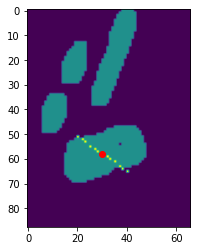

In [23]:
start_time = time.clock()
centre, angle, obj_image = get_arm_pos(img1, img2)
print(f"Time elapsed: {round(time.clock() - start_time, 2)}s")

img = add_line(centre, radians(angle), obj_image)
plt.imshow(img)
plt.scatter(centre[1], centre[0], c="r")
plt.show()

# TODO:
1. Fix rotation not working above (what changed to make it stop working?)
2. Optimise parameters